In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import git
import pathlib

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)
    
from libs.constants import model_seeds, error_seeds

In [4]:
model_meta_type = "mnist32-cnn"
error_layer = "c0"
MAX_FAULT_PROB_list = [1E-3]
ERR_PARAM_list = [1,-1]
ERR_NAME_LIST = {1:"Flip-to-1",
                -1:"Bitflip"}

# err_tag = "LIM_" + f"{int(MAX_FAULT_PROB*1E3):02d}"
err_tag_list = ["LIM_" + f"{int(MAX_FAULT_PROB*1E3):02d}" for MAX_FAULT_PROB in MAX_FAULT_PROB_list]
    
param_tag = "ERR"
for ERR_PARAM in ERR_PARAM_list:
    param_tag = param_tag + "_"+ str(ERR_PARAM)    
    
#################
#HANDIPLAST
###################
MAX_FAULT_PROB = 1E-3
error_meta_type = "LIM_" + f"{int(MAX_FAULT_PROB*1E3):02d}" + "-" + param_tag

In [5]:
results_folder = pathlib.Path(PROJ_ROOT_PATH / "notebooks"/ "ga" / model_meta_type /error_meta_type )
results_filename = 'evaluate_ga_genes-mnist32-cnn--LIM_01--c0--ERR_1_-1.npy'
results_file = pathlib.Path(results_folder / results_filename )
results = np.load(str(results_file), allow_pickle='TRUE').item()

In [6]:
model_seeds = list(results.keys())
error_profiles = list(results[model_seeds[0]].keys())[1:]

In [7]:
# given err_tag
# for all model seeds
# for all error seeds

In [8]:
fig_values = {}

In [9]:
fig_values["original_accs"] = {}
dummy = []
for model_seed in model_seeds:
    dummy.append(results[model_seed]["original_acc"])
fig_values["original_accs"]["avg"] = np.mean(dummy)
fig_values["original_accs"]["std"] = np.std(dummy)

In [10]:

for ERR_PARAM in ERR_PARAM_list:
    fig_values[ERR_PARAM] = {}
    for err_tag in err_tag_list:
        fig_values[ERR_PARAM][err_tag] = {}
        fig_values[ERR_PARAM][err_tag]["faulty"] = {}
        fig_values[ERR_PARAM][err_tag]["ga_optim"] = {}
        fig_values[ERR_PARAM][err_tag]["recovery"] = {}

        dummy_faulty = []
        dummy_ga_optim = []
        dummy_recovery = []
        for model_seed in model_seeds[0:2]:
            for error_seed in error_seeds[0:2]:
                error_profile_tag = err_tag+"-"+str(error_seed)
                
                faulty = results[model_seed][error_profile_tag][ERR_PARAM][error_layer]["faulty"]
                ga_optim = results[model_seed][error_profile_tag][ERR_PARAM][error_layer]["ga_optim"]
                recovery = ga_optim - faulty
                
                dummy_faulty.append(faulty)
                dummy_ga_optim.append(ga_optim)
                dummy_recovery.append(recovery)
                
                
        fig_values[ERR_PARAM][err_tag]["faulty"]["avg"] = np.mean(dummy_faulty)
        fig_values[ERR_PARAM][err_tag]["faulty"]["std"] = np.std(dummy_faulty)
        
        fig_values[ERR_PARAM][err_tag]["ga_optim"]["avg"] = np.mean(dummy_ga_optim)
        fig_values[ERR_PARAM][err_tag]["ga_optim"]["std"] = np.std(dummy_ga_optim)
        
        fig_values[ERR_PARAM][err_tag]["recovery"]["avg"] = np.mean(dummy_recovery)
        fig_values[ERR_PARAM][err_tag]["recovery"]["std"] = np.std(dummy_recovery)

In [11]:
fig_values

{'original_accs': {'avg': 0.9931126644736843, 'std': 0.0003083881578947456},
 1: {'LIM_01': {'faulty': {'avg': 0.890248081140351,
    'std': 0.030888897717010602},
   'ga_optim': {'avg': 0.9683730811403508, 'std': 0.0069065722668512075},
   'recovery': {'avg': 0.07812499999999992, 'std': 0.02533009137513422}}},
 -1: {'LIM_01': {'faulty': {'avg': 0.8723444353070176,
    'std': 0.04203570613099497},
   'ga_optim': {'avg': 0.9474883497807017, 'std': 0.0268047647276789},
   'recovery': {'avg': 0.07514391447368424, 'std': 0.02925564741763525}}}}

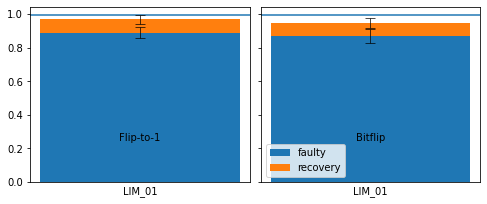

In [22]:
# Plot figure
fig_width = 3.125/0.8 * 2
fig_height = fig_width / 1.618 /1.5
n_rows = 1
n_cols = len(ERR_PARAM_list)
fig, axs = plt.subplots(nrows=n_rows,
                        ncols=n_cols,
                        figsize=[fig_width,fig_height], # in inches
                        sharex=True,
                        sharey=True,
                        constrained_layout=False, 
                        # tight_layout=True
                       )
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

for idx, ERR_PARAM in enumerate(ERR_PARAM_list):
    ax = axs[idx]
    
    # Print type of error
    text = ERR_NAME_LIST[ERR_PARAM]
    ax.text(0.5, 0.25, 
           text, 
           horizontalalignment='center', 
           verticalalignment='center', 
           transform=ax.transAxes)
    
    
    ax.set_xticks( [],[])   
    ax.set_xlabel(err_tag)
    
    # Plot original accuracy line
    ax.axhline(y=fig_values["original_accs"]["avg"])
    ax.axhspan(fig_values["original_accs"]["avg"] - fig_values["original_accs"]["std"], 
               fig_values["original_accs"]["avg"] + fig_values["original_accs"]["std"], alpha=0.5)

    # Plot faulty + recovery
    yhts = [fig_values[ERR_PARAM][err_tag]["faulty"]["avg"],
           fig_values[ERR_PARAM][err_tag]["ga_optim"]["avg"]]
    yerrs = [fig_values[ERR_PARAM][err_tag]["faulty"]["std"],
           fig_values[ERR_PARAM][err_tag]["ga_optim"]["std"]]

    y_offset = 0
    for val_type in ["faulty", "recovery"]:
        x_root = 0
        x_offset = 0
        ax.bar(x=x_root+x_offset,
               height=fig_values[ERR_PARAM][err_tag][val_type]["avg"],
               width=0.3,
               bottom=y_offset,
               yerr=fig_values[ERR_PARAM][err_tag][val_type]["std"],
               label=val_type,
               error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1, alpha=0.7))

        y_offset = y_offset + fig_values[ERR_PARAM][err_tag][val_type]["avg"]
ax.legend()